In [113]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import pickle
import re
import math
from collections import deque

%matplotlib inline

IMG_SHAPE = (600, 800)

PARAMS = {
    "min_dist_y1" : 170,
    "max_dist_y1" : 250,
    "min_dist_y2" : 170,
    "max_dist_y2" : 250,
    "min_dist_y3" : 10,
    "max_dist_y3" : 1000,
    
    'VALIDATE_Y2': 0.20,
    'VALIDATE_Y3': 0.75
}
CLASSES = {
    "SOLID" : 1,
    "DASH" : 2,
    "SOLID-SOLID" : 3,
    "DASH-SOLID" : 4,
    "SOLID-DASH" : 5,
    "NONE" : -1,
    "EMPTY" : 0
}
WINDOW_PARAMS = {
    'nb_windows' : 12, # number of sliding windows
    'margin' : 70, # width of the windows +/- margin
    'minpix' : 50, # min number of pixels needed to recenter the window
    
    'min_lane_pts' : 10  # min number of 'hot' pixels needed to fit a 2nd order polynomial as a 
}
WINDOW_HEITH = int(IMG_SHAPE[0] / WINDOW_PARAMS['nb_windows']),
    
destination = 'all'

In [71]:


def get_roi(img, vertices):
    '''
    Transforms an image by preserving only the ROI represented by the
    the 'vertices' and removes the remainder of the image by setting the pixel intensity to 0
    :param img (ndarray): Image
    :param vertices (ndarray): Region of Interest of the image
    :return : Modified image
    '''
    
    vertices = np.array(vertices, ndmin=3, dtype=np.int32)
    if len(img.shape) == 3:
        fill_color = (255,) * 3
    else:
        fill_color = 255
            
    mask = np.zeros_like(img)
    mask = cv2.fillPoly(mask, vertices, fill_color)
    return cv2.bitwise_and(img, mask)
    
def warp_image(img, warp_shape, src, dst):
    '''
    Performs perspective transformation (PT)
    :param img (ndarray): Image
    :param warp_shape: Shape of the warped image
    :param src (ndarray): Source points
    :param dst (ndarray): Destination points
    :return : Tuple (Transformed image, PT matrix, PT inverse matrix)
    '''
    
    # Get the perspective transformation matrix and its inverse
    M = cv2.getPerspectiveTransform(src, dst)
    invM = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image
    warped = cv2.warpPerspective(img, M, warp_shape, flags=cv2.INTER_LINEAR)
    return warped, M, invM

def preprocess_image(img, visualise=False):
    '''
    Pre-processes an image. Steps include:
    1. Distortion correction
    2. Perspective Transformation
    3. ROI crop
    
    :param img (ndarray): Original Image
    :param visualise (boolean): Boolean flag for visualisation
    :return : Pre-processed image, (PT matrix, PT inverse matrix)
    '''
    
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    # 1. Distortion correction
    undist = img
    
    # 2. Perspective transformation
    """
    src = np.float32([
        (449,370),    
        (348,370), 
        (192,593),  
        (612,593)
    ])
    """
    
    src = np.float32([
        (436,342),    
        (365,342), 
        (158,593),  
        (645,593)
    ])

    dx = 300
    dst = np.float32([
        (xsize - dx, 0),
        (dx, 0),
        (dx, ysize),
        (xsize - dx, ysize)
    ])

    warped, M, invM = warp_image(undist, (xsize, ysize), src, dst)

    # 3. ROI crop
    vertices = np.array([
        [200, ysize],
        [200, 0],
        [600, 0],
        [600, ysize]
    ])

    roi = get_roi(warped, vertices)

    # 4. Visualise the transformation
    if visualise:
        img_copy = np.copy(img)
        roi_copy = np.copy(roi)
        
        cv2.polylines(img_copy, [np.int32(src)], True, 1, 3)
        cv2.polylines(roi_copy, [np.int32(dst)], True, 1, 3)
        
        plot_images([
            (img_copy, 'Original Image'),
            (roi_copy, 'Bird\'s Eye View Perspective')
            #(warped, "warped")
        ])

    return roi, (M, invM)

def get_image(img_path, visualise=False):

    img = cv2.imread(img_path)
    #img = (img.sum(axis = 2) == 441).astype("uint8")
    return preprocess_image(img, visualise=visualise)

In [72]:
def plot_images(data, layout='row', cols=2, figsize=(20, 12)):
    '''
    Utility function for plotting images
    :param data [(ndarray, string)]: List of data to display, [(image, title)]
    :param layout (string): Layout, row-wise or column-wise
    :param cols (number): Number of columns per row
    :param figsize (number, number): Tuple indicating figure size
    '''
    rows = math.ceil(len(data) / cols)
    f, ax = plt.subplots(figsize=figsize)
    if layout == 'row':
        for idx, d in enumerate(data):
            img, title = d

            plt.subplot(rows, cols, idx+1)
            plt.title(title, fontsize=20)
            #plt.axis('off')
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
                #print(img.max())
            elif len(img.shape) == 3:
                plt.imshow(img)
                
    elif layout == 'col':
        counter = 0
        for r in range(rows):
            for c in range(cols):
                img, title = data[r + rows*c]
                nb_channels = len(img.shape)
                
                plt.subplot(rows, cols, counter+1)
                plt.title(title, fontsize=20)
                #plt.axis('off')
                if len(img.shape) == 2:
                    plt.imshow(img, cmap='gray')
                
                elif len(img.shape) == 3:
                    plt.imshow(img)
              
                counter += 1
    plt.show()

    return ax

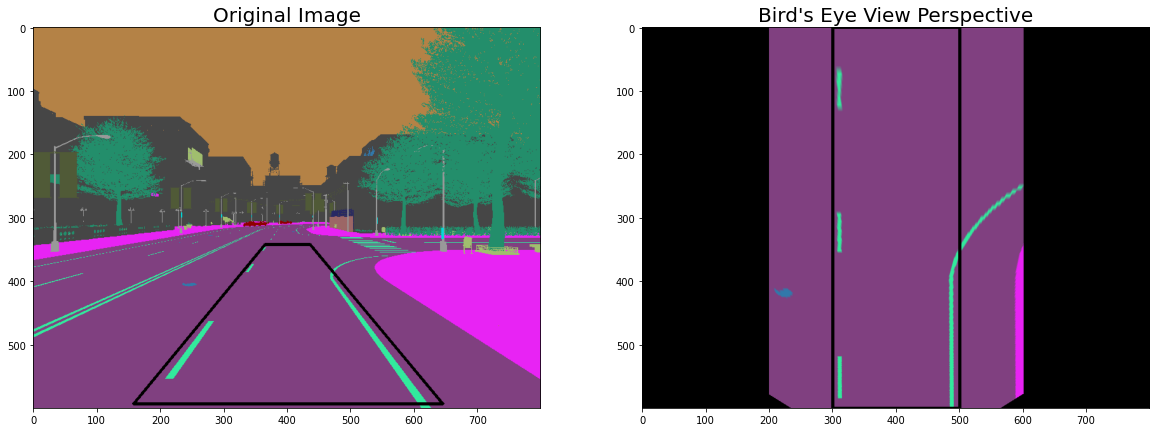

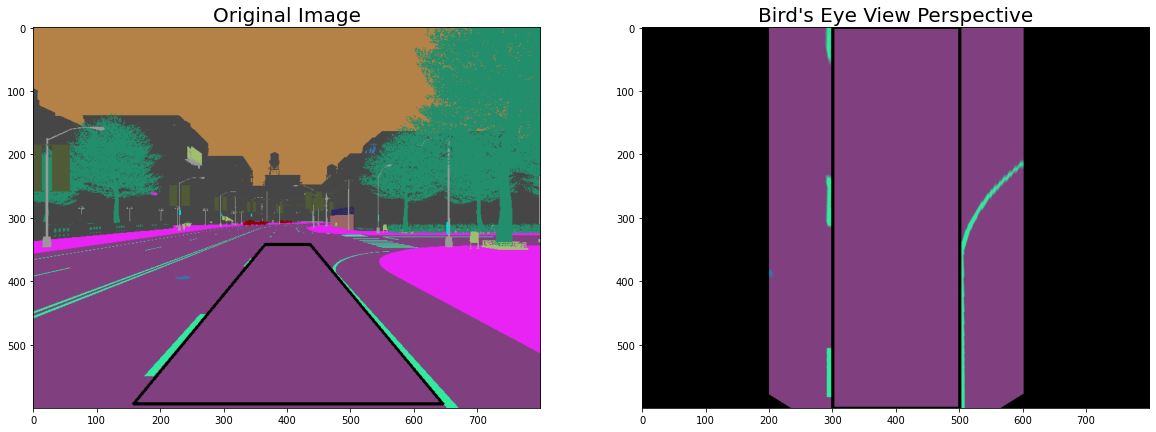

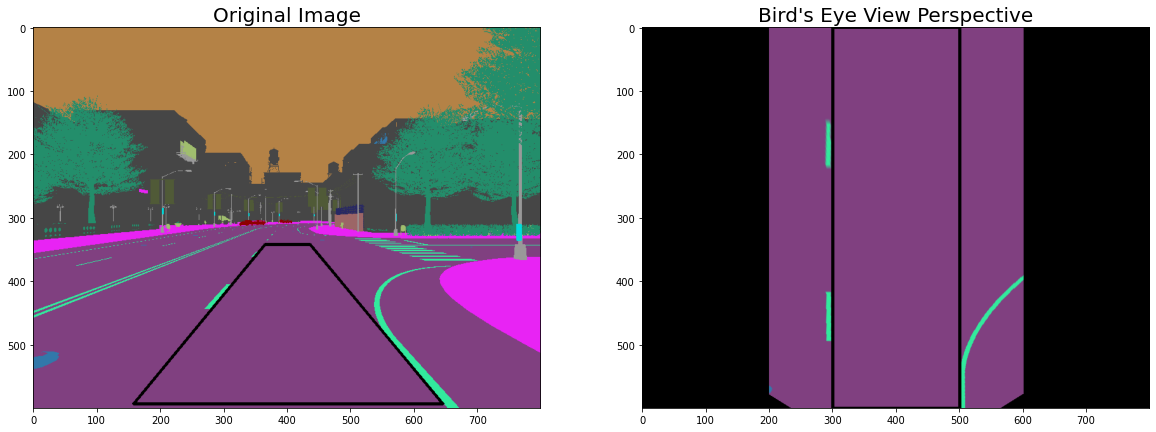

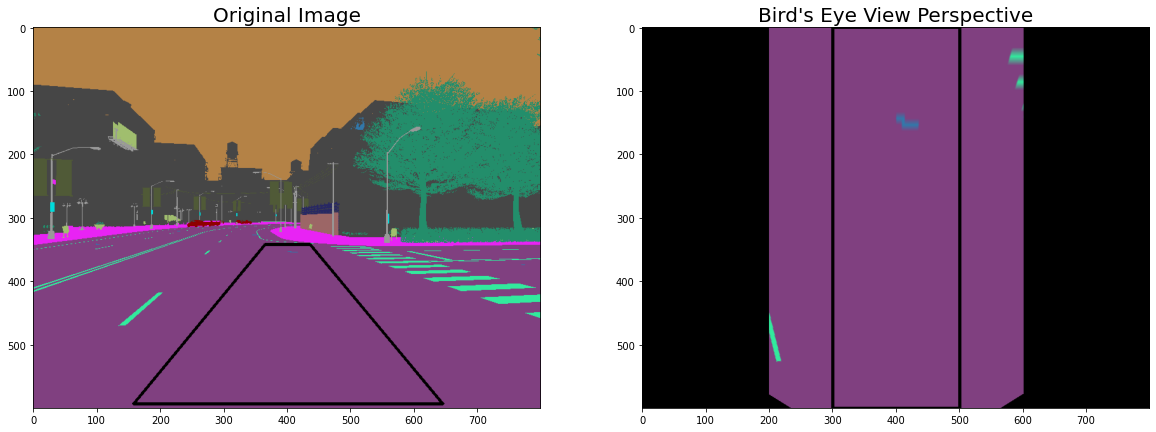

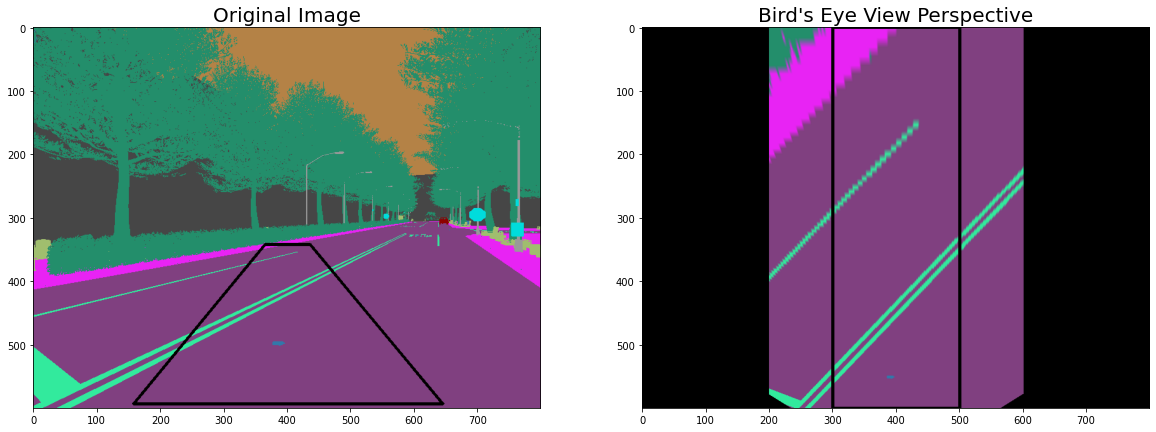

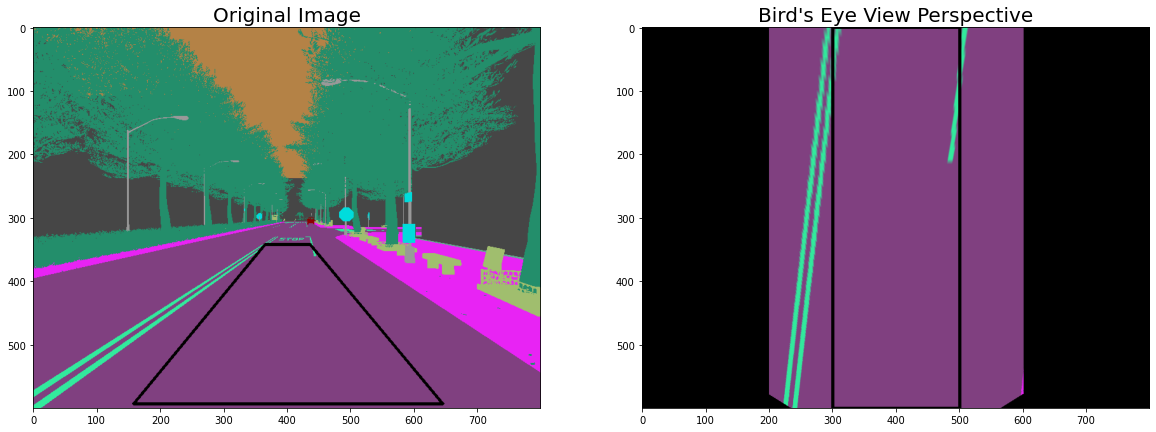

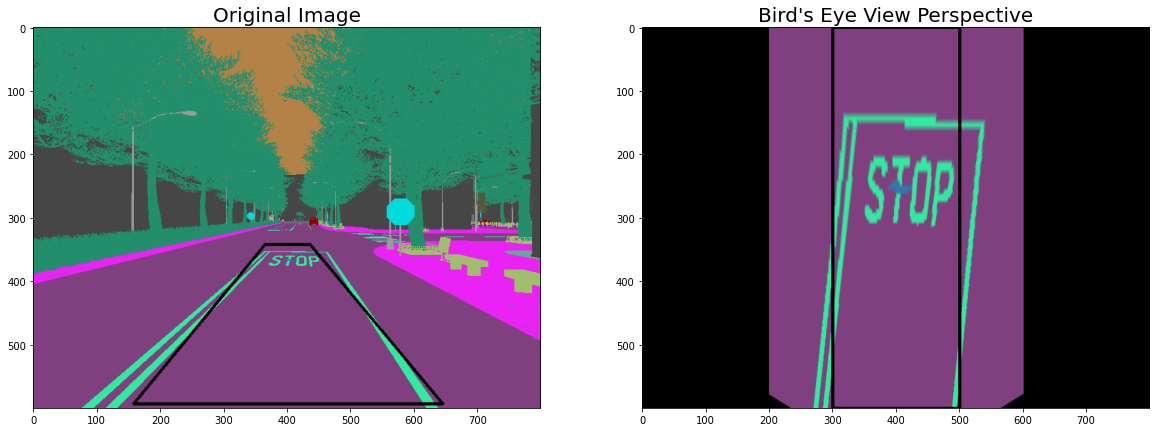

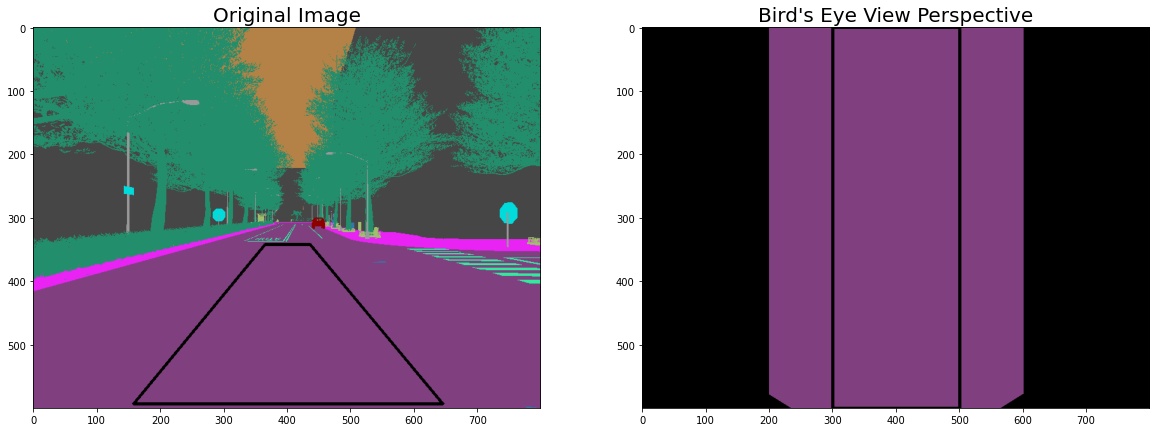

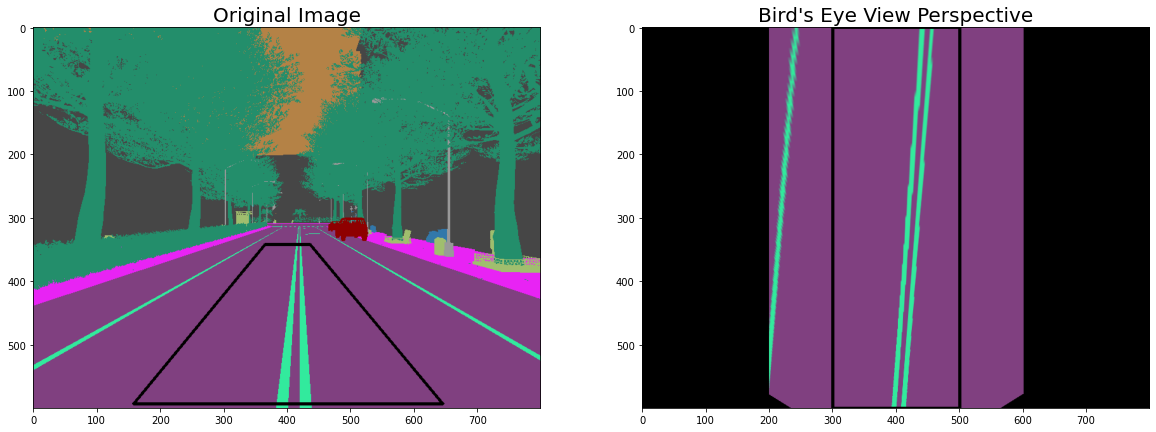

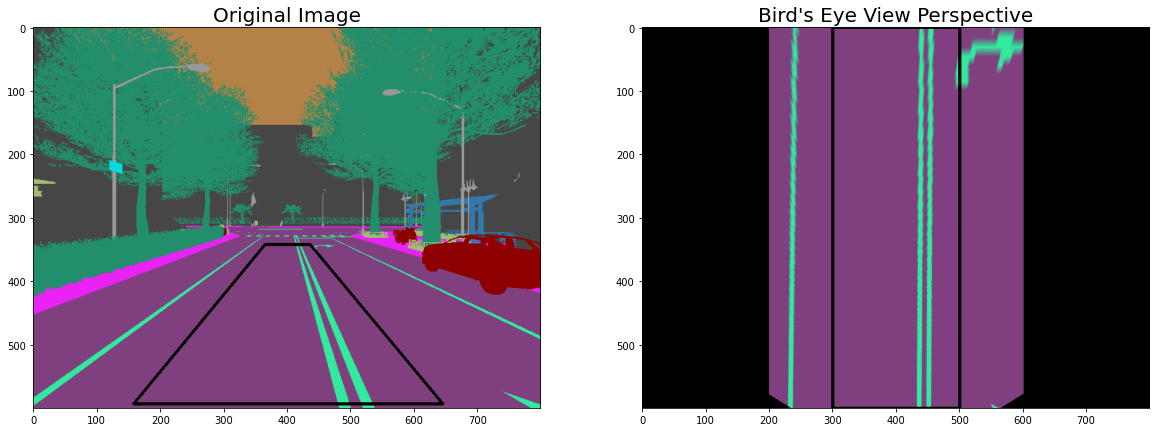

In [73]:
for i in range(1,100,10):
    img, *b = get_image(os.path.join(destination,str(i) + ".png"), True)

In [107]:
def get_poly_points(left_fit, right_fit):
    '''
    Get the points for the left lane/ right lane defined by the polynomial coeff's 'left_fit'
    and 'right_fit'
    :param left_fit (ndarray): Coefficients for the polynomial that defines the left lane line
    :param right_fit (ndarray): Coefficients for the polynomial that defines the right lane line
    : return (Tuple(ndarray, ndarray, ndarray, ndarray)): x-y coordinates for the left and right lane lines
    '''
    ysize, xsize = IMG_SHAPE
    
    # Get the points for the entire height of the image
    plot_y = np.linspace(0, ysize-1, ysize)
    plot_xleft = left_fit[0] * plot_y**2 + left_fit[1] * plot_y + left_fit[2]
    plot_xright = right_fit[0] * plot_y**2 + right_fit[1] * plot_y + right_fit[2]
    
    # But keep only those points that lie within the image
    plot_xleft = plot_xleft[(plot_xleft >= 0) & (plot_xleft <= xsize - 1)]
    plot_xright = plot_xright[(plot_xright >= 0) & (plot_xright <= xsize - 1)]
    plot_yleft = np.linspace(ysize - len(plot_xleft), ysize - 1, len(plot_xleft))
    plot_yright = np.linspace(ysize - len(plot_xright), ysize - 1, len(plot_xright))
    
    return plot_xleft.astype(np.int64), plot_yleft.astype(np.int64), plot_xright.astype(np.int64), plot_yright.astype(np.int64)

def check_validity(left_fit, right_fit, diagnostics=False):
    '''
    Determine the validity of lane lines represented by a set of second order polynomial coefficients 
    :param left_fit (ndarray): Coefficients for the 2nd order polynomial that defines the left lane line
    :param right_fit (ndarray): Coefficients for the 2nd order polynomial that defines the right lane line
    :param diagnostics (boolean): Boolean flag for logging
    : return (boolean)
    '''
    
    if left_fit is None or right_fit is None:
        return False
    
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)

    # Check whether the two lines lie within a plausible distance from one another for three distinct y-values

    y1 = IMG_SHAPE[0] - 1 # Bottom
    y2 = IMG_SHAPE[0] - int(min(len(plot_yleft), len(plot_yright)) * PARAMS['VALIDATE_Y2']) # For the 2nd and 3rd, take values between y1 and the top-most available value.
    y3 = IMG_SHAPE[0] - int(min(len(plot_yleft), len(plot_yright)) * PARAMS['VALIDATE_Y3'])

    # Compute the respective x-values for both lines
    x1l = left_fit[0]  * (y1**2) + left_fit[1]  * y1 + left_fit[2]
    x2l = left_fit[0]  * (y2**2) + left_fit[1]  * y2 + left_fit[2]
    x3l = left_fit[0]  * (y3**2) + left_fit[1]  * y3 + left_fit[2]

    x1r = right_fit[0] * (y1**2) + right_fit[1] * y1 + right_fit[2]
    x2r = right_fit[0] * (y2**2) + right_fit[1] * y2 + right_fit[2]
    x3r = right_fit[0] * (y3**2) + right_fit[1] * y3 + right_fit[2]

    # Compute the L1 norms
    x1_diff = abs(x1l - x1r)
    x2_diff = abs(x2l - x2r)
    x3_diff = abs(x3l - x3r)

    # Define the threshold values for each of the three points #FIT
    
    
    min_dist_y1 = PARAMS["min_dist_y1"] # 510 # 530 
    max_dist_y1 = PARAMS["max_dist_y1"] # 750 # 660
    min_dist_y2 = PARAMS["min_dist_y2"]
    max_dist_y2 = PARAMS["max_dist_y2"] # 660
    min_dist_y3 = PARAMS["min_dist_y3"]
    max_dist_y3 = PARAMS["max_dist_y3"] # 660
    
    if (x1_diff < min_dist_y1) | (x1_diff > max_dist_y1) | \
        (x2_diff < min_dist_y2) | (x2_diff > max_dist_y2) | \
        (x3_diff < min_dist_y3) | (x3_diff > max_dist_y3):
        if diagnostics:
            print("Violated distance criterion: " +
                  "x1_diff == {:.2f}, x2_diff == {:.2f}, x3_diff == {:.2f}".format(x1_diff, x2_diff, x3_diff))
        return False

    # Check whether the line slopes are similar for two distinct y-values
    # x = Ay**2 + By + C
    # dx/dy = 2Ay + B
    
    y1left_dx  = 2 * left_fit[0]  * y1 + left_fit[1]
    y3left_dx  = 2 * left_fit[0]  * y3 + left_fit[1]
    y1right_dx = 2 * right_fit[0] * y1 + right_fit[1]
    y3right_dx = 2 * right_fit[0] * y3 + right_fit[1]

    # Compute the L1-norm
    norm1 = abs(y1left_dx - y1right_dx)
    norm2 = abs(y3left_dx - y3right_dx)
    
#     if diagnostics: print( norm1, norm2)

    # Define the L1 norm threshold
    thresh = 10#0.6 #0.58 
    if (norm1 >= thresh) | (norm2 >= thresh):
        if diagnostics:
            print("Violated tangent criterion: " +
                  "norm1 == {:.3f}, norm2 == {:.3f} (thresh == {}).".format(norm1, norm2, thresh))
        return False
    
    return True

def polyfit_sliding_window(binary, lane_width_px=578, visualise=False, diagnostics=False):
    '''
    Detect lane lines in a thresholded binary image using the sliding window technique
    :param binary (ndarray): Thresholded binary image
    :param lane_width_px (int): Average lane line width (in px) for the warped image 
    computed empirically
    :param visualise (boolean): Boolean flag for visualisation
    :param diagnositics (boolean): Boolean flag for logging
    '''
    
    global cache
    ret = True

    # Sanity check
    if binary.max() <= 0:
        return False, np.array([]), np.array([]), np.array([])
    
    # Step 1: Compute the histogram along all the columns in the lower half of the image. 
    # The two most prominent peaks in this histogram will be good indicators of the
    # x-position of the base of the lane lines
    histogram = None
    cutoffs = [int(binary.shape[0] / 2), 0]
    
    for cutoff in cutoffs:
        histogram = np.sum(binary[cutoff:, :], axis=0)
        
        if histogram.max() > 0:
            break

    if histogram.max() == 0:
        print('Unable to detect lane lines in this frame. Trying another frame!')
        return False, np.array([]), np.array([])
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int64(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    if visualise:
        plot_images([(binary, 'Binary')])
        plt.plot(histogram, 'm', linewidth=4.0)
        plt.plot((midpoint, midpoint), (0, IMG_SHAPE[0]), 'c')
        plt.plot((0, IMG_SHAPE[1]), (cutoff, cutoff), 'c')

    out = np.dstack((binary, binary, binary)) * 255


                    # lane line
    
    # Identify the x-y positions of all nonzero pixels in the image
    # Note: the indices here are equivalent to the coordinate locations of the
    # pixel
    nonzero = binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    classes_left = np.array([0]* nb_windows)
    classes_right = np.array([0]* nb_windows)
    
    def (nonzerox,nonzeroy)
    
    for window in range(nb_windows):
        # Identify window boundaries in x and y (and left and right)
        win_y_low = IMG_SHAPE[0] - (1 + window) * window_height
        win_y_high = IMG_SHAPE[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin

        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw windows for visualisation
        cv2.rectangle(out, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),\
                      (0, 255, 0), 2)
        cv2.rectangle(out, (win_xright_low, win_y_low), (win_xright_high, win_y_high),\
                      (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)
                         & (nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)
                         & (nonzerox >= win_xright_low) & (nonzerox <= win_xright_high)).nonzero()[0]
        
        classes_left[window] = classify(binary,win_xleft_high, win_y_high, win_xleft_low, win_y_low)
        classes_right[window] = classify(binary,win_xright_high, win_y_high, win_xright_low, win_y_low)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if(classes_left[window] != CLASSES['NONE']):
            left_lane_inds.append(good_left_inds)
            if len(good_left_inds) >  minpix:
                mean = int(np.mean(nonzerox[good_left_inds]))
                leftx_current = mean 
                
        if(classes_right[window] != CLASSES['NONE']):
            right_lane_inds.append(good_right_inds)
            if len(good_right_inds) > minpix:
                mean = int(np.mean(nonzerox[good_right_inds]))
                rightx_current = mean
        
    
    print(classes_left,classes_right)
    
    left_final_CLASS = classify_by_seq(classes_left)
    left_final_CLASS = classify_by_seq(classes_right)
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract pixel positions for the left and right lane lines
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = None, None
    
    # Sanity check; Fit a 2nd order polynomial for each lane line pixels
    if len(leftx) >= min_lane_pts and len(rightx) >= min_lane_pts:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Validate detected lane lines
    valid = check_validity(left_fit, right_fit, diagnostics=diagnostics)
    print("VALID: ",valid)
    if not valid:
        # If the detected lane lines are NOT valid:
        # 1. Compute the lane lines as an average of the previously detected lines
        # from the cache and flag this detection cycle as a failure by setting ret=False
        # 2. Else, if cache is empty, return 
        
        if len(cache) == 0:
            if diagnostics: print('WARNING: Unable to detect lane lines in this frame.')
            return False, np.array([]), np.array([])
        
        avg_params = np.mean(cache, axis=0)
        left_fit, right_fit = avg_params[0], avg_params[1]
        ret = False
        
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)

    # Color the detected pixels for each lane line
    out[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 10, 255]

    left_poly_pts = np.array([np.transpose(np.vstack([plot_xleft, plot_yleft]))])
    right_poly_pts = np.array([np.transpose(np.vstack([plot_xright, plot_yright]))])

    # Plot the fitted polynomial
    cv2.polylines(out, np.int32([left_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)
    cv2.polylines(out, np.int32([right_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)

    if visualise:
        plot_images([(out, 'Out')], figsize=(30, 40))
        
    return ret, out, np.array([left_fit, right_fit])

In [108]:

def classify(binary,x_high, y_high, x_low, y_low):
    
    summs = list()
    
    for i in range(y_low,y_high):
        summ = 0
        for j in range(x_low,x_high - 1):
            summ += binary[i,j] ^ binary[i,j + 1]
        summs.append(summ)
        
    MAX = max(summs)
    MIN = min(summs)
    MEAN = np.mean(summs)
    
    #TODO #######################################
    #add sigma
    carrent_class = CLASSES["EMPTY"]
    if(MAX == 0):
        current_class =  CLASSES["EMPTY"]
    elif(MAX == 2) and (MIN == 0):
        current_class =  CLASSES["DASH"]
    elif(MEAN == 2):
        current_class =  CLASSES['SOLID']
    elif(MEAN == 4):
        current_class = CLASSES['SOLID-SOLID']
    elif(MAX == 4) and (MIN == 2):
        current_class = CLASSES['DASH-SOLID']
    else:
        current_class =  CLASSES["NONE"]

    return current_class


def classify_by_seq(windows):
    arr = np.insert(windows,0,CLASSES['NONE'])
    
    # DASH if prev EMPTY next SOLID and vice versa
    length = len(arr)
    for i in range(1,length):
        prev_class = arr[i-1]
        current_class = arr[i]
        
        if (current_class == CLASSES['SOLID'] and prev_class == CLASSES["EMPTY"]):
            arr[i] = CLASSES['DASH'] 
        
        elif(current_class == CLASSES["EMPTY"] and prev_class == CLASSES["SOLID"]):
            arr[i - 1] = CLASSES['DASH'] 
         
    # Strong line if it is 4 times in a row
    Count_of_SS_in_row = max(np.diff(np.where(arr !=  CLASSES['SOLID-SOLID'])[0]) - 1)
    if(Count_of_SS_in_row > 4):
        return  CLASSES['SOLID-SOLID']
    
    Count_of_S_in_row = max(np.diff(np.where(arr !=  CLASSES['SOLID'])[0]) - 1)
    if(Count_of_S_in_row > 4):
        return  CLASSES['SOLID'] 
    
    # set MAX priority class if it is here at least 2 times
    counts = set()
    MAX = 0
    for element in arr:
        if(element in counts):
            if (element > MAX):
                MAX = element
        else:
            counts.add(element)
    return  MAX
    

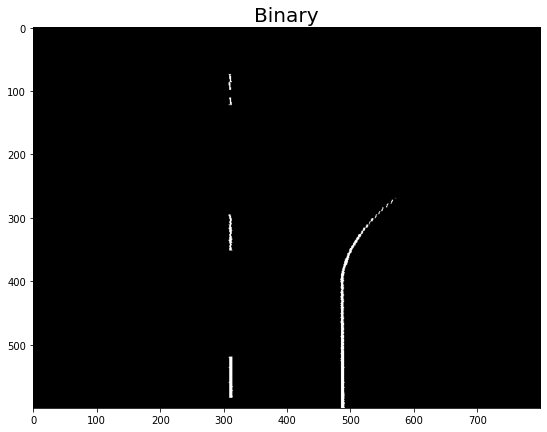

[2 2 0 0 2 1 2 0 0 2 2 0] [1 1 1 1 1 1 2 0 0 0 0 0]
VALID:  True


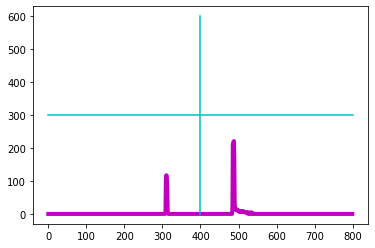

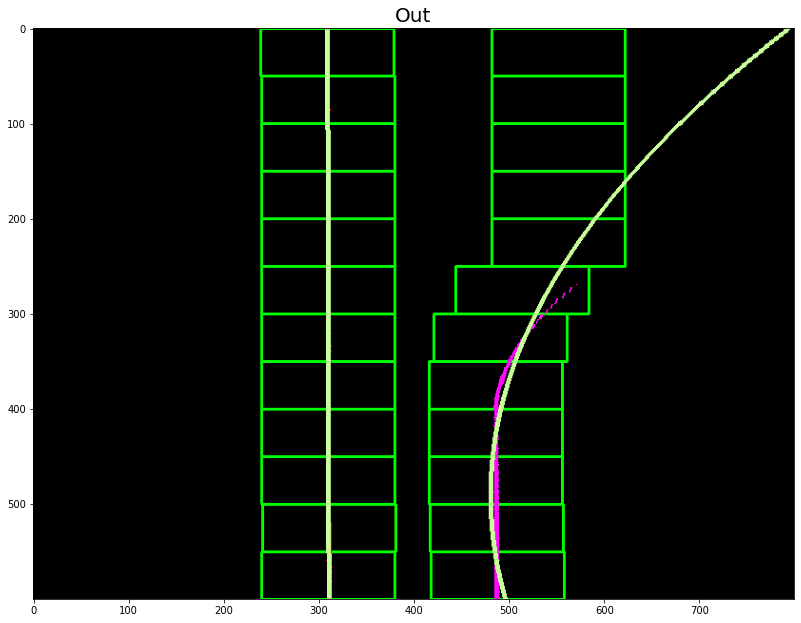

In [109]:

#cache = deque(maxlen = PARAMS['MAX_CACHE_LEN'])
cache = np.array([])
for i in range(1,2):
    img_path = os.path.join(destination,str(i) + ".png")
    img = cv2.imread(img_path)
    
    warped, (M,invM) = get_image(img_path)
    binary = (warped.sum(axis = 2) == 441).astype("uint8")

    polyfit_sliding_window(binary, visualise=True,diagnostics=True)

In [ ]:
def draw(img, warped, invM, poly_param):
    '''
    Utility function to draw the lane boundaries and numerical estimation of lane curvature and vehicle position.
    :param img (ndarray): Original image
    :param warped (ndarray): Warped image
    :param invM (ndarray): Inverse Perpsective Transformation matrix
    :param poly_param (ndarray): Set of 2nd order polynomial coefficients that represent the detected lane lines
    
    :param offset (float32): Car offset
    :return (ndarray): Image with visual display
    '''
    
    undist = img
    warp_zero = np.zeros_like(warped[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fit = poly_param[0]
    right_fit = poly_param[1]
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)
    
    pts_left = np.array([np.transpose(np.vstack([plot_xleft, plot_yleft]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([plot_xright, plot_yright])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Color the road
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 220, 110))
                    
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False,
                  color=(255, 255, 255), thickness=10)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False,
                  color=(255, 255, 255), thickness= 10)
    
    # Unwarp and merge with undistorted original image
    unwarped = cv2.warpPerspective(color_warp, invM, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    out = cv2.addWeighted(undist, 1, unwarped, 0.4, 0)

    
    return out

[-1 -1  3  3  3  3  3  3  3 -1  0  0] [ 3  3  3  3  3  3  3  3  3 -1  0  0]
9
(3336,)
VALID:  False
[]


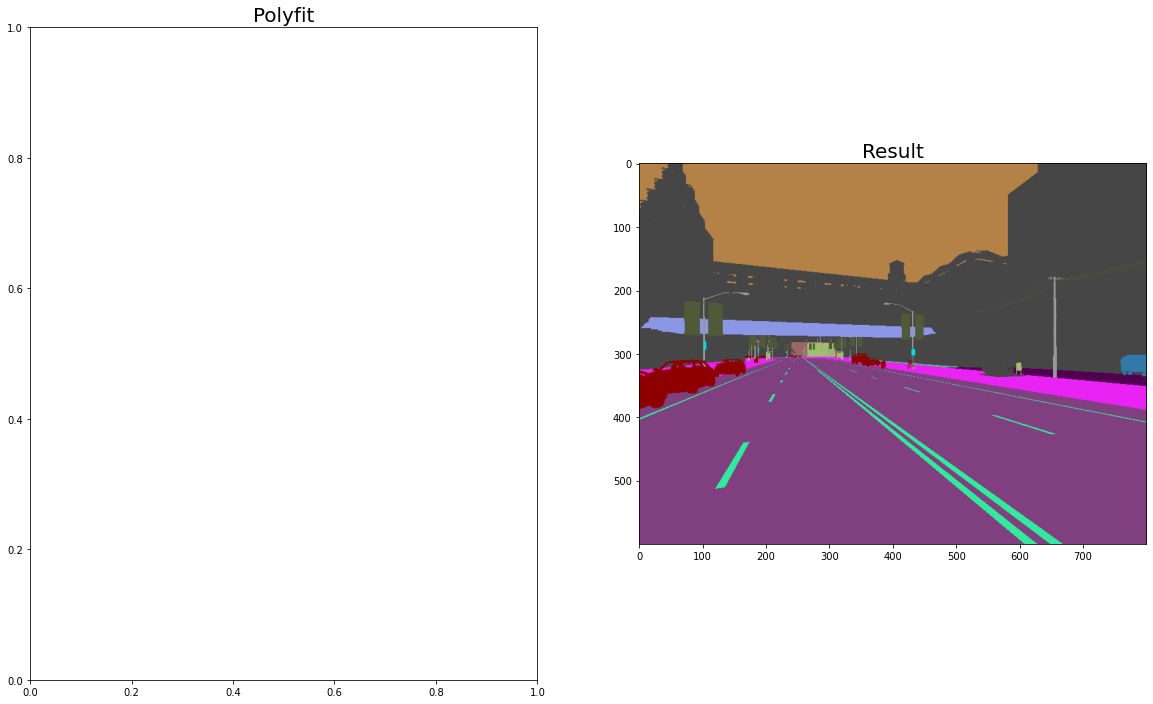

[-1 -1  3  3  3  3  3  3  4  2  0  0] [3 3 3 3 3 3 3 3 4 2 0 0]
10
(3501,)
VALID:  False
[]


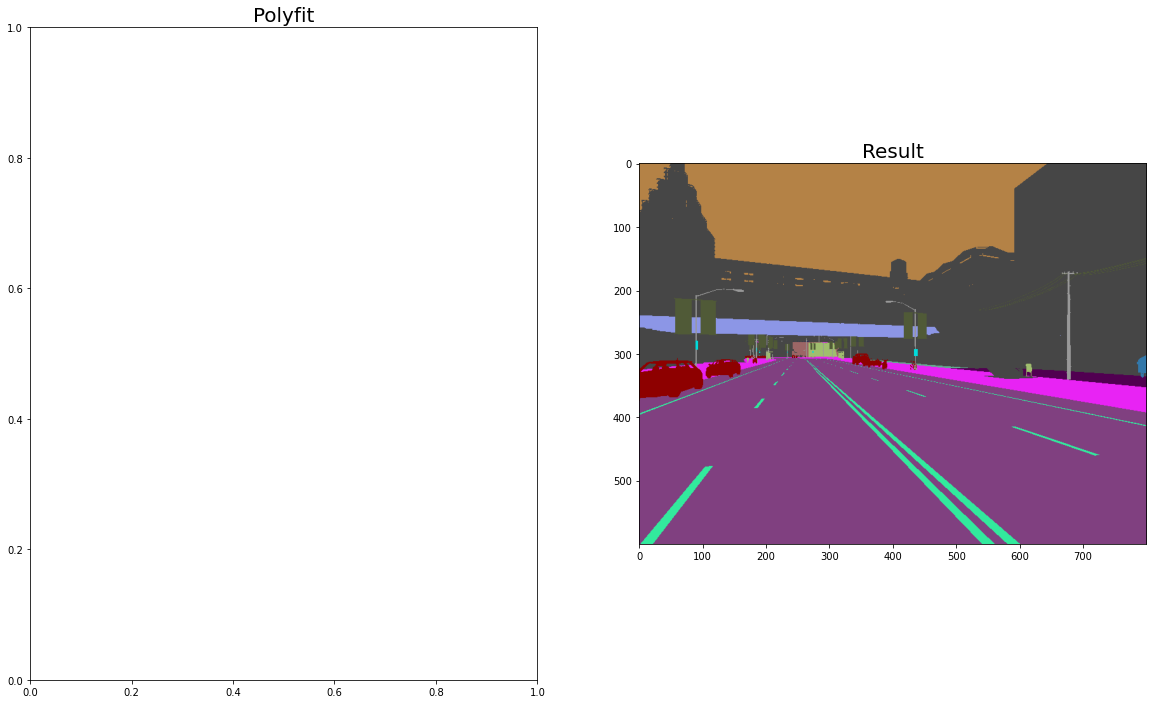

[0 2 3 3 3 3 3 4 2 0 0 0] [3 3 3 3 3 3 3 4 2 0 0 0]
12
(3503,)
VALID:  False
[]


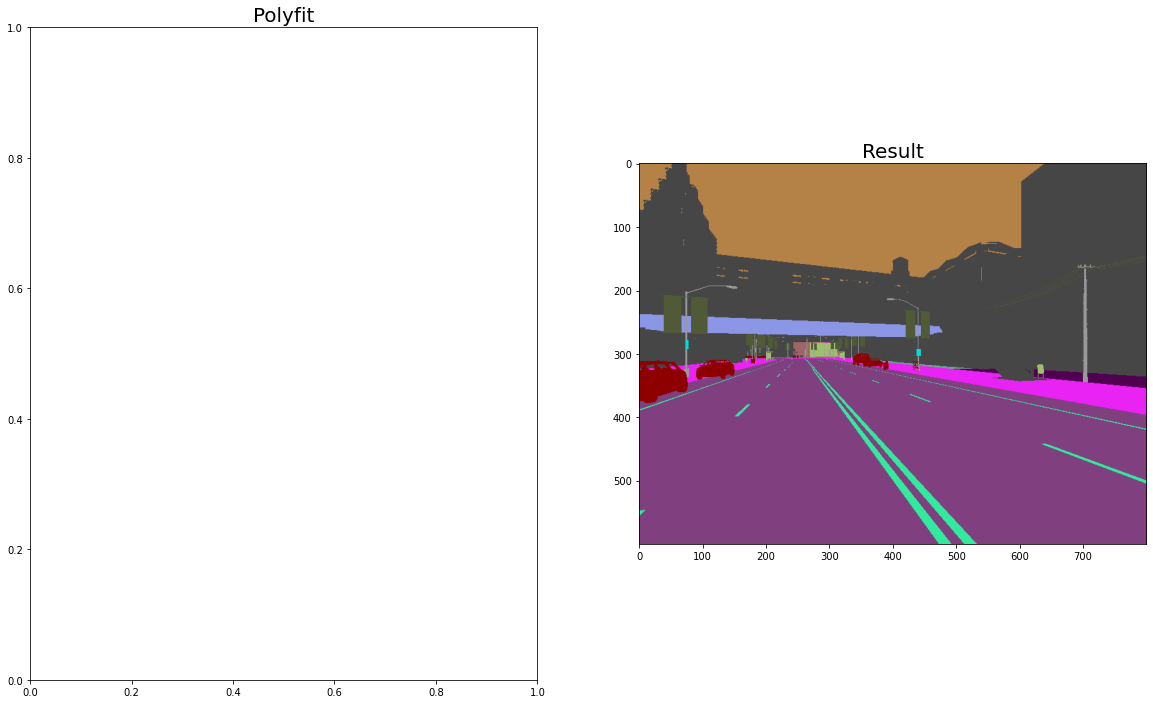

[ 3  3  3  3  3  3  3 -1  0  0  0  0] [ 3  3  3  3  3  3  3 -1  0  0  0  0]
11
(4426,)
VALID:  False
[]


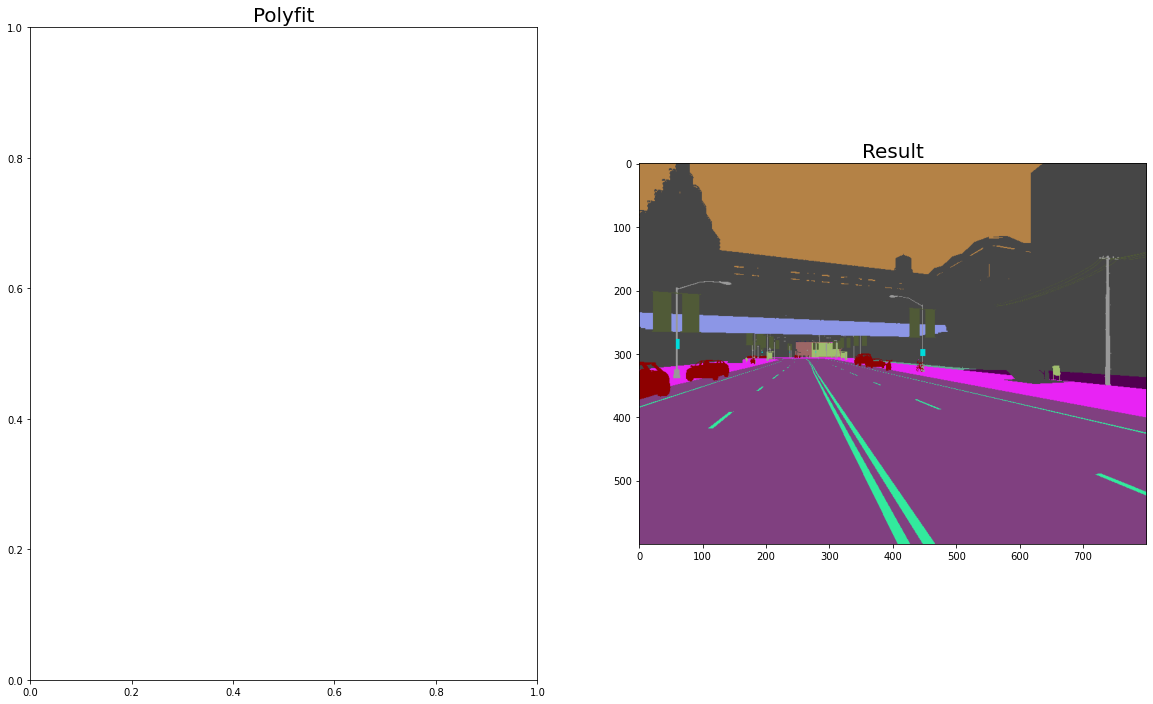

[ 4  3  3  3  3  3 -1  0  0  0  0  0] [0 0 0 2 1 2 0 0 0 0 2 2]
11
(3905,)
VALID:  False
[]


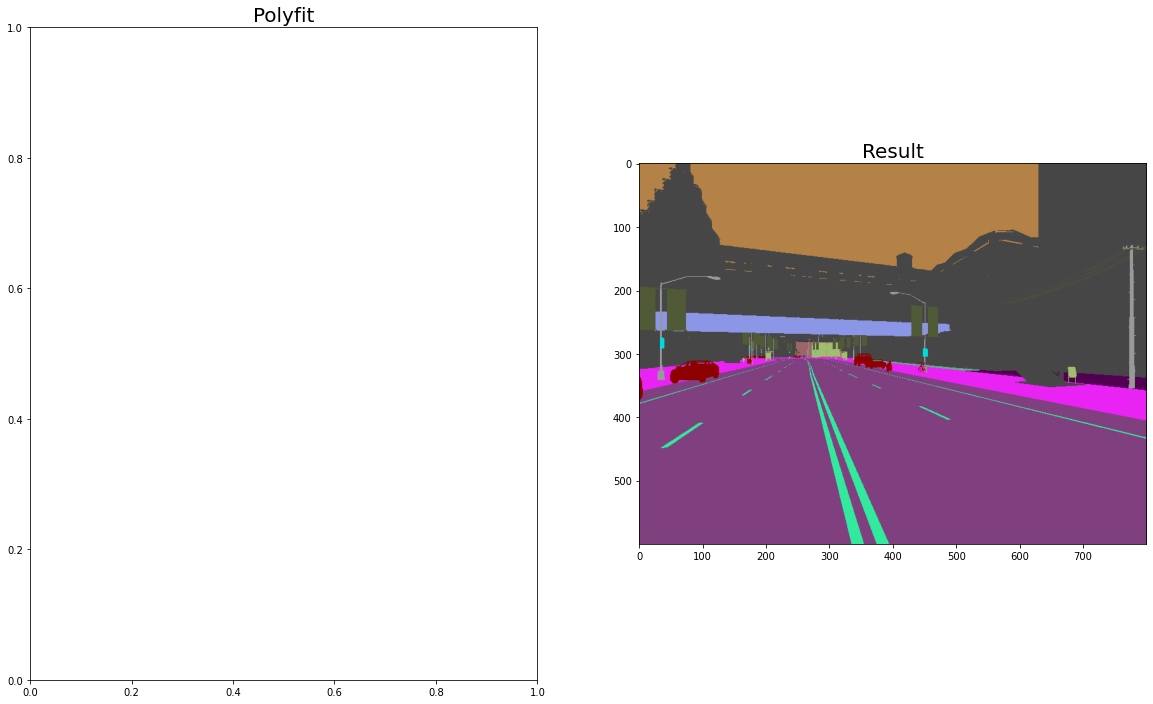

[-1 -1  3  3  3  4  2  0  0  0  0  0] [0 0 2 1 2 0 0 0 0 2 2 2]
10
(2496,)
VALID:  False
[]


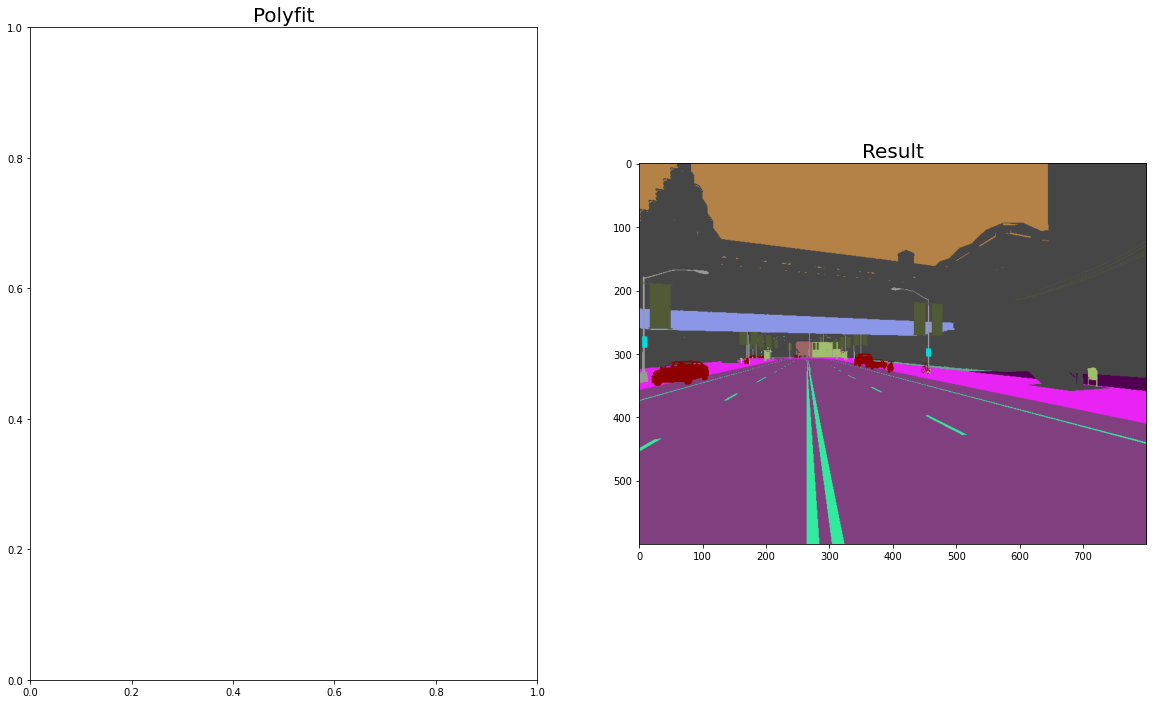

[3 3 3 3 3 4 2 0 0 0 0 0] [0 2 1 0 0 0 0 0 0 2 2 2]
12
(4191,)
VALID:  True
[[ 1.12606158e-04  3.59335797e-01  8.86874383e+01]
 [ 5.42514782e-04 -3.30686385e-01  5.43259701e+02]]


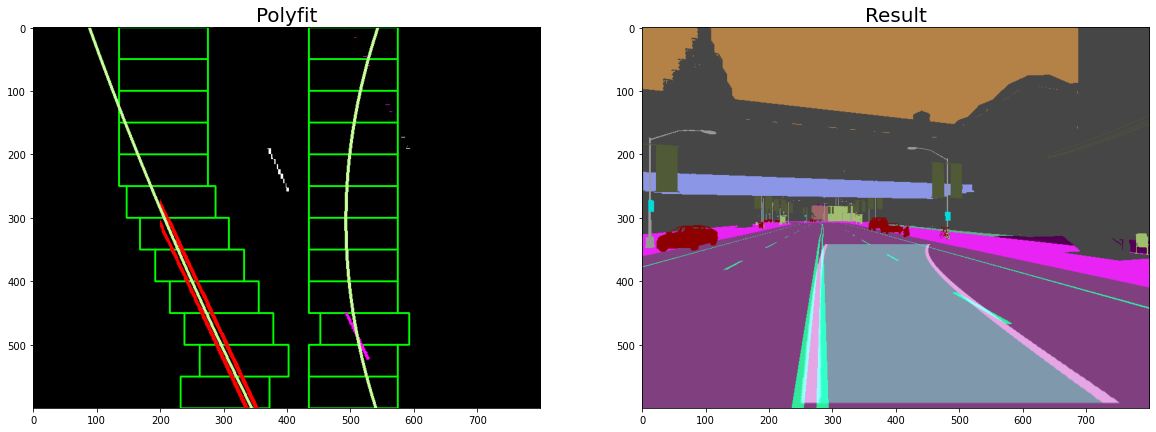

[3 3 3 3 3 3 3 3 3 4 2 0] [ 2  2  0  0  0 -1 -1  0  0  0  0  2]
12
(6176,)
VALID:  True
[[ 4.61025245e-05  2.72486314e-01  1.75023960e+02]
 [ 7.39252009e-04 -4.88719287e-01  5.99397525e+02]]


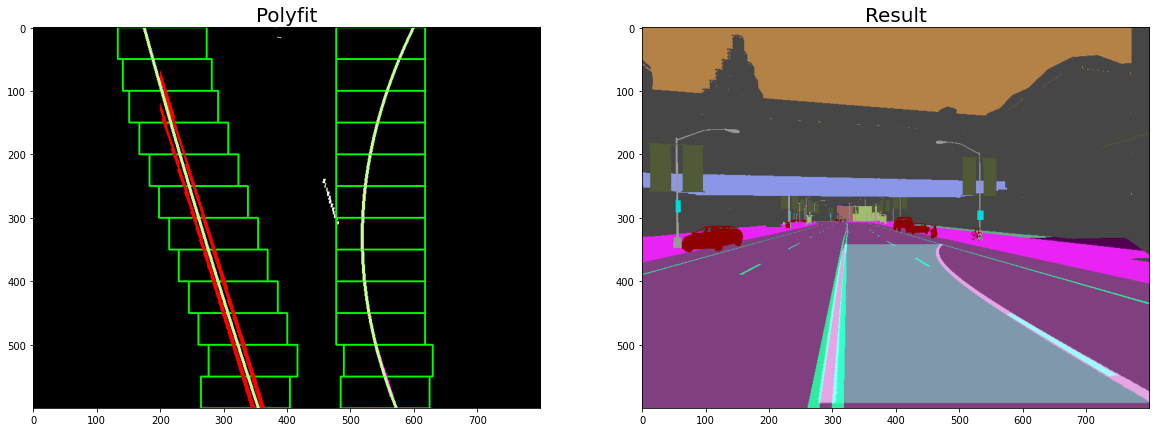

[3 3 3 3 3 3 3 3 3 3 3 3] [2 0 0 0 2 1 2 0 0 0 2 2]


ValueError: max() arg is an empty sequence

In [97]:

cache = np.array([])
for i in range(590,620,1):
    img_path = os.path.join(destination,str(i) + ".png")
    img = cv2.imread(img_path)
    
    warped, (M,invM) = get_image(img_path)
    binary = (warped.sum(axis = 2) == 441).astype("uint8")
    #ret, img_poly, poly_param =polyfit_sliding_window(binary,visualise=True,diagnostics=True)
    ret, img_poly, poly_param =polyfit_sliding_window(binary)
    print(poly_param)
    if(len(poly_param) != 0):
        result = draw(img, warped, invM, poly_param)
        plot_images([(img_poly, 'Polyfit'), (result, 'Result')])
    else:
        plot_images([(img_poly, 'Polyfit'), (img, 'Result')])

In [ ]:
CLASSES

In [ ]:
import numpy as np

X = np.array([[5.], [4.], [3.], [2.], [1.]])
X = np.insert(X, 0, 6.)
X